In [ ]:
!pip install gluonts
!pip install autogluon

ERROR: Operation cancelled by user
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... canceled
ERROR: Operation cancelled by user


In [ ]:
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.evaluation.metrics import mse
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pred_df = pd.read_pickle('/content/drive/My Drive/lag_llama_elec_BE_C3w_P24h_pred.pkl')
pred_df['diff'] = pred_df['step1'] - pred_df['actual']
pred_df_1 = pred_df[['time', 'diff']]

# Add an 'item_id' column to train_df
pred_df_1['item_id'] = '0'  # Assuming a single time series, assign '0' as the item_id


<ipython-input-5-19153c76eff3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df_1['item_id'] = '0'  # Assuming a single time series, assign '0' as the item_id


In [ ]:
pred_df_1

,time,diff,item_id
0,2016-11-12 00:00:00,-9.739853,0
1,2016-11-12 01:00:00,-16.084141,0
2,2016-11-12 02:00:00,-12.995888,0
3,2016-11-12 03:00:00,-3.818047,0
4,2016-11-12 04:00:00,0.346622,0
...,...,...,...
1171,2016-12-30 19:00:00,0.235260,0
1172,2016-12-30 20:00:00,-6.456539,0
1173,2016-12-30 21:00:00,-6.537251,0
1174,2016-12-30 22:00:00,-9.229122,0


In [ ]:
# Initialize variables
historical_days = 21
window_size = 24 * historical_days  # 24 hours a day
prediction_length = 1  # Predict 24 hours

pred_dict = {}
actual_dict = {}
best_model_name = []

# Iterate through the time series data by rolling window
for start_idx in range(len(pred_df_1) - window_size):
    # Slice the data for the current rolling window
    rolling_window = pred_df_1.iloc[start_idx : start_idx + window_size]

    # Convert train_df to a TimeSeriesDataFrame
    train_data = TimeSeriesDataFrame.from_data_frame(
        rolling_window,
        id_column='item_id',  # Specify the item_id column
        timestamp_column='time'  # Specify the timestamp column
    )

    # Fit the TimeSeriesPredictor on the rolling window
    predictor = TimeSeriesPredictor(
        prediction_length=prediction_length,
        path="multiple-timeseries/electric-hourly-error-fast",
        target="diff",
        eval_metric="MSE",
    )
    predictor.fit(train_data, presets="fast_training", random_seed=42)

    # Predict the next hour
    prediction = predictor.predict(train_data, random_seed=42)

    # Add the predictions to the list
    pred_dict[pred_df_1.iloc[start_idx + window_size].time] = prediction['mean'].values[0]
    actual_dict[pred_df_1.iloc[start_idx + window_size].time] = pred_df_1.iloc[start_idx + window_size]['diff']

    best_model_name.append(predictor.info()["best_model"])

Streaming output truncated to the last 5000 lines.
{'enable_ensemble': True,
 'eval_metric': MSE,
 'hyperparameters': 'very_light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'diff',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 504 rows, 1 time series. Median time series length is 504 (min=504, max=504). 

Provided data contains following columns:
	target: 'diff'

AutoGluon will gauge predictive performance using evaluation metric: 'MSE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-13 01:49:28
Models that will be trained: ['Naive', 'SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'ETS', 'Theta']
Train

In [ ]:
# Assuming pred_dict is defined as in the original code
# Create an empty list to store the data for the DataFrame
data_pred = []

# Iterate through the pred_dict
for date, prediction in pred_dict.items():
  # Create a dictionary for each date's predictions
  row = {'time': date}
  row['pred_diff'] = prediction
  data_pred.append(row)

# Create the DataFrame
pred_df = pd.DataFrame(data_pred)

actual_df = pd.DataFrame(list(actual_dict.items()), columns=['time', 'actual'])

# Convert 'time' column to datetime objects if they are not already
actual_df['time'] = pd.to_datetime(actual_df['time'])
pred_df['time'] = pd.to_datetime(pred_df['time'])

# Merge the DataFrames on the 'time' column
merged_df = pd.merge(actual_df, pred_df, on='time', how='inner')
merged_df['best_model'] = best_model_name
merged_df

,time,actual,pred_diff,best_model
0,2016-12-03 00:00:00,-7.540310,1.246554,WeightedEnsemble
1,2016-12-03 01:00:00,-10.090706,-7.540310,Naive
2,2016-12-03 02:00:00,-4.023380,-10.090706,Naive
3,2016-12-03 03:00:00,-0.021690,-0.773355,WeightedEnsemble
4,2016-12-03 04:00:00,-1.349400,0.485586,WeightedEnsemble
...,...,...,...,...
667,2016-12-30 19:00:00,0.235260,3.604141,SeasonalNaive
668,2016-12-30 20:00:00,-6.456539,0.768528,WeightedEnsemble
669,2016-12-30 21:00:00,-6.537251,-2.399243,DirectTabular
670,2016-12-30 22:00:00,-9.229122,-6.537251,Naive


In [ ]:
merged_df.to_pickle('/content/drive/My Drive/predicting_error_autogluon_3W.pkl')

In [ ]:
#Predictions for error from Auto-gluon
error_pred = pd.read_pickle('/content/drive/My Drive/predicting_error_autogluon_3W.pkl')
error_pred.rename(columns = {'actual':'act_diff'}, inplace = True)


#predictions from Lag-LLama model
pred_df = pd.read_pickle('/content/drive/My Drive/lag_llama_elec_BE_C3w_P24h_pred.pkl')
pred_df = pred_df[['time', 'actual', 'step1']]
pred_df.rename(columns = {'step1':'pred'}, inplace = True)

In [ ]:
error_pred

,time,act_diff,pred_diff,best_model
0,2016-12-03 00:00:00,-7.540310,1.246554,WeightedEnsemble
1,2016-12-03 01:00:00,-10.090706,-7.540310,Naive
2,2016-12-03 02:00:00,-4.023380,-10.090706,Naive
3,2016-12-03 03:00:00,-0.021690,-0.773355,WeightedEnsemble
4,2016-12-03 04:00:00,-1.349400,0.485586,WeightedEnsemble
...,...,...,...,...
667,2016-12-30 19:00:00,0.235260,3.604141,SeasonalNaive
668,2016-12-30 20:00:00,-6.456539,0.768528,WeightedEnsemble
669,2016-12-30 21:00:00,-6.537251,-2.399243,DirectTabular
670,2016-12-30 22:00:00,-9.229122,-6.537251,Naive


In [ ]:
#inner join of predictions_df with pred_df on time column
merged_df = pd.merge(error_pred, pred_df, on='time', how='inner')
merged_df.drop(columns = ['best_model'], inplace = True)
merged_df

,time,act_diff,pred_diff,actual,pred
0,2016-12-03 00:00:00,-7.540310,1.246554,65.190002,57.649693
1,2016-12-03 01:00:00,-10.090706,-7.540310,55.889999,45.799294
2,2016-12-03 02:00:00,-4.023380,-10.090706,48.220001,44.196621
3,2016-12-03 03:00:00,-0.021690,-0.773355,46.590000,46.568310
4,2016-12-03 04:00:00,-1.349400,0.485586,46.310001,44.960602
...,...,...,...,...,...
667,2016-12-30 19:00:00,0.235260,3.604141,57.419998,57.655258
668,2016-12-30 20:00:00,-6.456539,0.768528,57.560001,51.103462
669,2016-12-30 21:00:00,-6.537251,-2.399243,52.180000,45.642750
670,2016-12-30 22:00:00,-9.229122,-6.537251,54.380001,45.150879


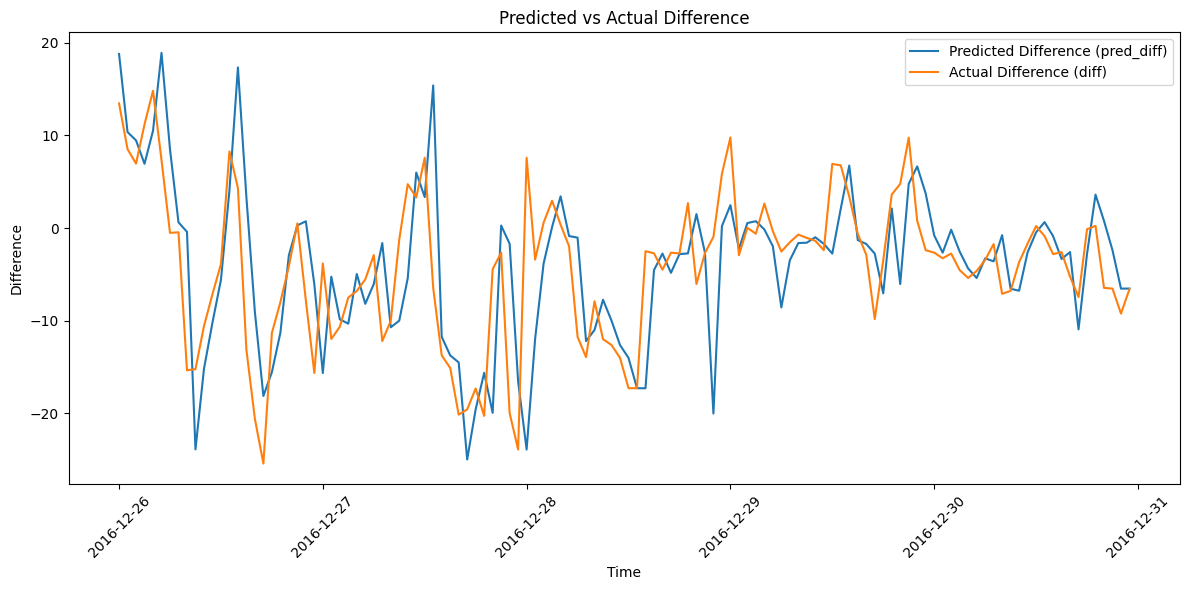

In [ ]:
#the graph for the last 5 days of pred_diff, diff as actual and fill in tthe plot using 0.1 to 0.9 columns as confidennce interval,

import matplotlib.pyplot as plt

last_5_days = merged_df.tail(5 * 24)  #hourly data

plt.figure(figsize=(12, 6))

# Plot pred_diff
plt.plot(last_5_days['time'], last_5_days['pred_diff'], label='Predicted Difference (pred_diff)')

# Plot diff (actual)
plt.plot(last_5_days['time'], last_5_days['act_diff'], label='Actual Difference (diff)')


plt.xlabel('Time')
plt.ylabel('Difference')
plt.title('Predicted vs Actual Difference')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
merged_df['adj_lagllama_pred'] = merged_df['pred'] - merged_df['pred_diff']

In [ ]:
from sklearn.metrics import mean_squared_error

# calculate MSE

# Calculate MSE of pred_diff keeping diff as reference
mse_pred_diff = mean_squared_error(merged_df['act_diff'], merged_df['pred_diff']) # Use mean_squared_error from sklearn.metrics
print(f"MSE of pred_diff: {mse_pred_diff}")

# Calculate MSE of lallama_pred keeping actual as reference
mse_lagllama_pred = mean_squared_error(merged_df['actual'], merged_df['pred']) # Use mean_squared_error from sklearn.metrics
print(f"MSE of lagllama_pred: {mse_lagllama_pred}")

# Calculate MSE of adj_lagllama_pred keeping actual as reference
mse_adj_lagllama_pred = mean_squared_error(merged_df['actual'], merged_df['adj_lagllama_pred']) # Use mean_squared_error from sklearn.metrics
print(f"MSE of adj_lagllama_pred: {mse_adj_lagllama_pred}")

MSE of pred_diff: 59.17041893426025
MSE of lagllama_pred: 180.37667846679688
MSE of adj_lagllama_pred: 59.17041893426025
